In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

import torch
from torch_geometric.utils import from_networkx
from ipaddress import IPv4Address
import random
import logging
from torch_geometric.loader import DataLoader
import pickle

# Train Graph

In [2]:
filename = './low_priority'
dataset = torch.load(f'{filename}.pt')

C:\Users\Noah\AppData\Local\Temp\ipykernel_32520\2891856823.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dataset = torch.load(f'{filename}.pt')


In [3]:
import torch
from torch_geometric.datasets import TUDataset
from pprint import pprint


print(len(dataset))
data = dataset[0]  # Get the first graph object.

print()
print(data)
print('=============================================================')

# Gather some statistics about the first graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

38289

Data(edge_index=[2, 12], feature=[4, 108], num_nodes=4, x=[4, 108], y=0)
Number of nodes: 4
Number of edges: 12
Average node degree: 3.00
Has isolated nodes: False
Has self-loops: False
Is undirected: True


In [4]:
import random

random.shuffle(dataset)
# train_dataset = dataset[:12000]
# test_dataset = dataset[12000:]

size = len(dataset)
size = size - size//4

train_dataset = dataset[:size]
test_dataset = dataset[size:]


print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')
    

Number of training graphs: 28717
Number of test graphs: 9572


In [5]:
n = len(test_dataset)
count = 0
for t in test_dataset:
    if t.y.item() == 0:
        count+=1

print(f'\033[1mPercent of not compromised graphs: \033[0m{count/n}')

Percent of not compromised graphs: 0.9194525699958211


In [6]:
import torch
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.loader import DataLoader

#Specify device manually
use_gpu = True # Set to False to use CPU
device = torch.device('cuda' if use_gpu and torch.cuda.is_available() else 'cpu')

print(f"Using device: {device}")


# DataLoader (ensure `train_dataset` and `test_dataset` are loaded correctly)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Define the GCN model
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(dataset[0].x.shape[1], hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, 0x3FFFF)

    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings 
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        
        return x

model = GCN(hidden_channels=64)
print(model)

Using device: cuda
GCN(
  (conv1): GCNConv(108, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (lin): Linear(in_features=64, out_features=262143, bias=True)
)


In [ ]:
from sklearn.metrics import precision_score, recall_score


# Initialize the model, optimizer, and loss function
model = GCN(hidden_channels=64).to(device)  # Move model to GPU
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

losses = []  # Training losses
test_losses = []  # Test losses
accs = []  # Test accuracies
precisions = []  # Test precisions
recalls = []  # Test recalls

# Define the training loop
def train():
    model.train()
    total_loss = 0

    for data in train_loader:  # Iterate in batches over the training dataset.
        data = data.to(device)  # Move batch data to GPU
        out = model(data.x, data.edge_index, data.batch)  # Perform a single forward pass.
        loss = criterion(out, data.y)  # Compute the loss.
        total_loss += loss.item()  # Accumulate loss for this epoch.
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        optimizer.zero_grad()  # Clear gradients.

    avg_loss = total_loss / len(train_loader)  # Calculate average loss for this epoch.
    losses.append(avg_loss)  # Append the average loss to the list.

# Define the testing loop
def test(loader):
    model.eval()
    correct = 0
    total_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():  # Disable gradient computation during evaluation.
        for data in loader:  # Iterate in batches over the training/test dataset.
            data = data.to(device)  # Move batch data to GPU
            out = model(data.x, data.edge_index, data.batch)
            loss = criterion(out, data.y)  # Compute the loss for the batch.
            total_loss += loss.item()  # Accumulate test loss.
            pred = out.argmax(dim=1)  # Use the class with highest probability.
            correct += int((pred == data.y).sum())  # Check against ground-truth labels.

            # Collect predictions and true labels for precision and recall
            all_preds.extend(pred.cpu().numpy())
            all_labels.extend(data.y.cpu().numpy())

    avg_loss = total_loss / len(loader)  # Calculate average test loss.
    test_losses.append(avg_loss)  # Append the average test loss to the list.
    acc = correct / len(loader.dataset)  # Derive ratio of correct predictions.
    accs.append(acc)  # Append accuracy to the list.

    # Compute precision and recall
    precision = precision_score(all_labels, all_preds, average='macro',zero_division=0)
    recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)
    precisions.append(precision)
    recalls.append(recall)

    return acc, avg_loss, precision, recall

# Training and testing loop
for epoch in range(1, 101):
    train()
    test_acc, test_loss, precision, recall = test(test_loader)
    print(f'Epoch: {epoch:03d}, Train Loss: {losses[-1]:.4f}, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}')


## Graphs

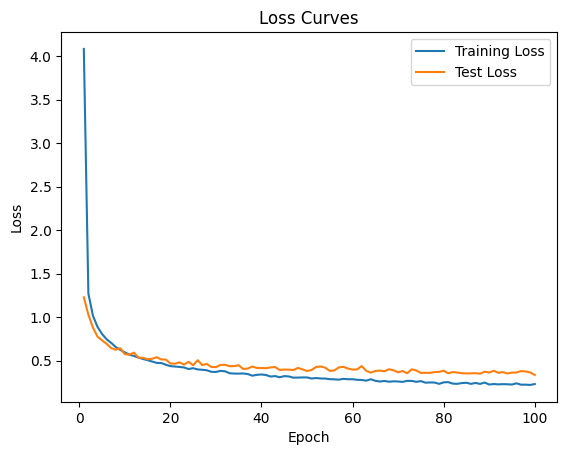

In [ ]:
# Plot the loss curve
plt.plot(range(1, 101), losses, label='Training Loss')
plt.plot(range(1,101), test_losses, label='Test Loss')

plt.xlabel('Epoch')
plt.legend()
plt.ylabel('Loss')
plt.title('Loss Curves')
plt.savefig('../Data/loss_curves.png', dpi=300, bbox_inches='tight')
plt.show()


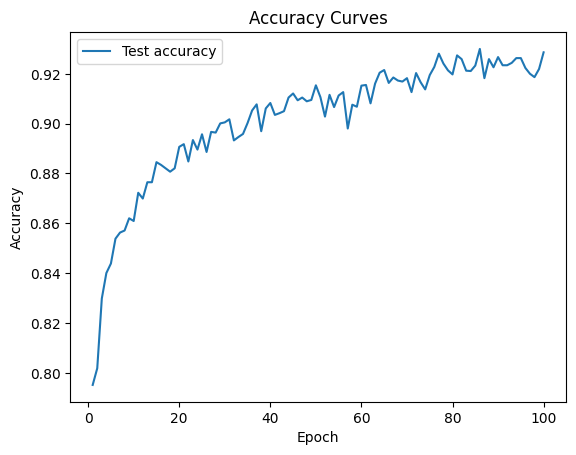

In [ ]:
plt.plot(range(1, 101), accs, label='Test accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylabel('Accuracy')
plt.title('Accuracy Curves')
plt.savefig('../Data/accuracy_curve.png', dpi=300, bbox_inches='tight')
plt.show()


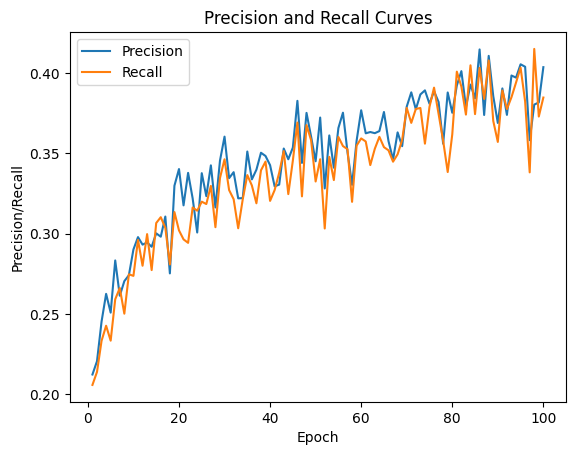

In [ ]:
plt.plot(range(1, 101), precisions, label='Precision')
plt.plot(range(1, 101), recalls, label='Recall')
plt.xlabel('Epoch')
plt.legend()
plt.ylabel('Precision/Recall')
plt.title('Precision and Recall Curves')
plt.savefig('../Data/precision_curve.png', dpi=300, bbox_inches='tight')
plt.show()